In [1]:
import os
from glob import glob # extract path of each file
import pandas as pd # data preprocessing
from xml.etree import ElementTree as et # parse information from XML
from functools import reduce

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# step-1: get path of each xml file
xmlfiles = glob('./data_images/*.xml')
# replace \\ with /
replace_text = lambda x: x.replace('\\','/')
xmlfiles = list(map(replace_text,xmlfiles))

In [6]:
xmlfiles

['./data_images/48.xml',
 './data_images/8.xml',
 './data_images/9.xml',
 './data_images/28.xml',
 './data_images/14.xml',
 './data_images/15.xml',
 './data_images/29.xml',
 './data_images/17.xml',
 './data_images/16.xml',
 './data_images/13.xml',
 './data_images/11.xml',
 './data_images/39.xml',
 './data_images/38.xml',
 './data_images/10.xml',
 './data_images/21.xml',
 './data_images/35.xml',
 './data_images/34.xml',
 './data_images/20.xml',
 './data_images/36.xml',
 './data_images/22.xml',
 './data_images/23.xml',
 './data_images/37.xml',
 './data_images/33.xml',
 './data_images/27.xml',
 './data_images/26.xml',
 './data_images/32.xml',
 './data_images/24.xml',
 './data_images/30.xml',
 './data_images/18.xml',
 './data_images/19.xml',
 './data_images/31.xml',
 './data_images/25.xml',
 './data_images/42.xml',
 './data_images/4.xml',
 './data_images/5.xml',
 './data_images/43.xml',
 './data_images/7.xml',
 './data_images/41.xml',
 './data_images/40.xml',
 './data_images/6.xml',
 './da

In [7]:
# step-2: read xml files
# from each xml file we need to extract
# filename, size(width, height), object(name, xmin, xmax, ymin, ymax)
def extract_text(filename):
    tree = et.parse(filename)
    root = tree.getroot()

    # extract filename
    image_name = root.find('filename').text
    # width and height of the image
    width = root.find('size').find('width').text
    height = root.find('size').find('height').text
    objs = root.findall('object')
    parser = []
    for obj in objs:
        name = obj.find('name').text
        bndbox = obj.find('bndbox')
        xmin = bndbox.find('xmin').text
        xmax = bndbox.find('xmax').text
        ymin = bndbox.find('ymin').text
        ymax = bndbox.find('ymax').text
        parser.append([image_name, width, height, name,xmin,xmax,ymin,ymax])
        
    return parser

In [8]:
parser_all = list(map(extract_text,xmlfiles))

In [9]:
data = reduce(lambda x, y : x+y,parser_all)

In [10]:
df = pd.DataFrame(data,columns = ['filename','width','height','name','xmin','xmax','ymin','ymax'])

In [11]:
df.head()

,filename,width,height,name,xmin,xmax,ymin,ymax
0,48.jpg,640,718,necklace,197,548,19,522
1,8.jpg,643,360,necklace,201,452,54,341
2,9.jpg,736,1308,necklace,99,211,127,403
3,9.jpg,736,1308,necklace,233,349,115,401
4,9.jpg,736,1308,necklace,355,497,100,443


In [12]:
df.shape

(82, 8)

In [13]:
df['name'].value_counts()

name
necklace    82
Name: count, dtype: int64

#### Conversion
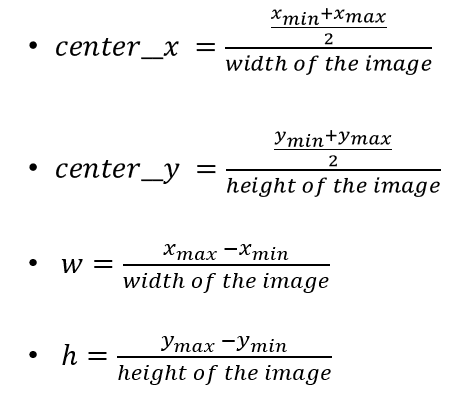

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  82 non-null     object
 1   width     82 non-null     object
 2   height    82 non-null     object
 3   name      82 non-null     object
 4   xmin      82 non-null     object
 5   xmax      82 non-null     object
 6   ymin      82 non-null     object
 7   ymax      82 non-null     object
dtypes: object(8)
memory usage: 5.3+ KB


In [15]:
# type conversion
cols = ['width','height','xmin','xmax','ymin','ymax']
df[cols] = df[cols].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  82 non-null     object
 1   width     82 non-null     int64 
 2   height    82 non-null     int64 
 3   name      82 non-null     object
 4   xmin      82 non-null     int64 
 5   xmax      82 non-null     int64 
 6   ymin      82 non-null     int64 
 7   ymax      82 non-null     int64 
dtypes: int64(6), object(2)
memory usage: 5.3+ KB


In [16]:
# center x, center y
df['center_x'] = ((df['xmax']+df['xmin'])/2)/df['width']
df['center_y'] = ((df['ymax']+df['ymin'])/2)/df['height']
# w 
df['w'] = (df['xmax']-df['xmin'])/df['width']
# h 
df['h'] = (df['ymax']-df['ymin'])/df['height']

In [17]:
df.head()

,filename,width,height,name,xmin,xmax,ymin,ymax,center_x,center_y,w,h
0,48.jpg,640,718,necklace,197,548,19,522,0.582031,0.376741,0.548438,0.700557
1,8.jpg,643,360,necklace,201,452,54,341,0.507776,0.548611,0.390358,0.797222
2,9.jpg,736,1308,necklace,99,211,127,403,0.210598,0.202599,0.152174,0.211009
3,9.jpg,736,1308,necklace,233,349,115,401,0.395380,0.197248,0.157609,0.218654
4,9.jpg,736,1308,necklace,355,497,100,443,0.578804,0.207569,0.192935,0.262232


### split data into train and test

In [18]:
images = df['filename'].unique()

In [19]:
len(images)

47

In [20]:
# 80% train and 20% test
img_df = pd.DataFrame(images,columns=['filename'])
img_train = tuple(img_df.sample(frac=0.8)['filename']) # shuffle and pick 80% of images

In [21]:
img_test = tuple(img_df.query(f'filename not in {img_train}')['filename']) # take rest 20% images

In [22]:
len(img_train), len(img_test)

(38, 9)

In [23]:
train_df = df.query(f'filename in {img_train}')
test_df = df.query(f'filename in {img_test}')

In [24]:
train_df.head()

,filename,width,height,name,xmin,xmax,ymin,ymax,center_x,center_y,w,h
1,8.jpg,643,360,necklace,201,452,54,341,0.507776,0.548611,0.390358,0.797222
2,9.jpg,736,1308,necklace,99,211,127,403,0.210598,0.202599,0.152174,0.211009
3,9.jpg,736,1308,necklace,233,349,115,401,0.395380,0.197248,0.157609,0.218654
4,9.jpg,736,1308,necklace,355,497,100,443,0.578804,0.207569,0.192935,0.262232
5,9.jpg,736,1308,necklace,519,675,78,416,0.811141,0.188838,0.211957,0.258410


In [25]:
test_df.head()

,filename,width,height,name,xmin,xmax,ymin,ymax,center_x,center_y,w,h
0,48.jpg,640,718,necklace,197,548,19,522,0.582031,0.376741,0.548438,0.700557
19,16.jpeg,581,1032,necklace,129,455,6,995,0.502582,0.484981,0.561102,0.958333
21,11.jpg,1280,720,necklace,16,572,2,701,0.229687,0.488194,0.434375,0.970833
22,11.jpg,1280,720,necklace,701,1145,3,694,0.721094,0.484028,0.346875,0.959722
40,36.jpg,541,919,necklace,186,398,274,613,0.539741,0.482590,0.391867,0.368879


### Assign id number to object names

In [26]:
# label encoding
def label_encoding(x):
    labels = {'necklace':0}
    return labels[x]

In [27]:
train_df['id'] = train_df['name'].apply(label_encoding)
test_df['id'] = test_df['name'].apply(label_encoding)

In [28]:
train_df.head(10)

,filename,width,height,name,xmin,xmax,ymin,ymax,center_x,center_y,w,h,id
1,8.jpg,643,360,necklace,201,452,54,341,0.507776,0.548611,0.390358,0.797222,0
2,9.jpg,736,1308,necklace,99,211,127,403,0.210598,0.202599,0.152174,0.211009,0
3,9.jpg,736,1308,necklace,233,349,115,401,0.395380,0.197248,0.157609,0.218654,0
4,9.jpg,736,1308,necklace,355,497,100,443,0.578804,0.207569,0.192935,0.262232,0
5,9.jpg,736,1308,necklace,519,675,78,416,0.811141,0.188838,0.211957,0.258410,0
6,9.jpg,736,1308,necklace,94,209,450,765,0.205842,0.464450,0.156250,0.240826,0
7,9.jpg,736,1308,necklace,226,350,453,768,0.391304,0.466743,0.168478,0.240826,0
8,9.jpg,736,1308,necklace,367,491,456,778,0.582880,0.471713,0.168478,0.246177,0
9,9.jpg,736,1308,necklace,504,658,453,774,0.789402,0.469037,0.209239,0.245413,0
10,9.jpg,736,1308,necklace,52,194,774,1073,0.167120,0.706040,0.192935,0.228593,0


### Save Image and Labels in text

In [29]:
import os
from shutil import move

In [30]:
train_folder = 'data_images/train'
test_folder = 'data_images/test'


os.mkdir(train_folder)
os.mkdir(test_folder)

In [31]:
cols = ['filename','id','center_x','center_y', 'w', 'h']
groupby_obj_train = train_df[cols].groupby('filename')
groupby_obj_test = test_df[cols].groupby('filename')

In [32]:
#groupby_obj_train.get_group('000009.jpg').set_index('filename').to_csv('sample.txt',index=False,header=False)
# save each image in train/test folder and repective labels in .txt
def save_data(filename, folder_path, group_obj):
    # move image
    src = os.path.join('data_images',filename)
    dst = os.path.join(folder_path,filename)
    move(src,dst) # move image to the destination folder
    
    # save the labels
    text_filename = os.path.join(folder_path,
                                 os.path.splitext(filename)[0]+'.txt')
    group_obj.get_group(filename).set_index('filename').to_csv(text_filename,sep=' ',index=False,header=False)
    

In [33]:
filename_series = pd.Series(groupby_obj_train.groups.keys())

In [34]:
filename_series.apply(save_data,args=(train_folder,groupby_obj_train))

0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
18    None
19    None
20    None
21    None
22    None
23    None
24    None
25    None
26    None
27    None
28    None
29    None
30    None
31    None
32    None
33    None
34    None
35    None
36    None
37    None
dtype: object

In [35]:
filename_series_test = pd.Series(groupby_obj_test.groups.keys())
filename_series_test.apply(save_data,args=(test_folder,groupby_obj_test))

0    None
1    None
2    None
3    None
4    None
5    None
6    None
7    None
8    None
dtype: object